In [1]:
from gym import Env
from gym.envs.registration import EnvSpec
import numpy as np
from gym.spaces import MultiDiscrete,Box
from graph_tool.all import *
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from makegraph import *
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def simulatepandemic(self,actions):
    action = np.divide(actions,np.sum(actions)) #relative availability of vaccine is calculated
    action = np.multiply(action,self.vacc_sum)
    if self.timestep == 0:
        update_firststate(self.g,action)
        print('check')
    else:
        update_state(self.g,action)
        print('nocheck')
    erate = extract_economy(self.g)
    self.state = graph_to_matrix(self.g)
    self.timestep += 1
    
    return self.state

def initializepandemic(self):
    self.g = make_graph(self.size,self.distribution)
    self.state = graph_to_matrix(self.g)
    return self.state

In [3]:
#the class is needed if we want to sample more frequently
from stable_baselines3.common.callbacks import BaseCallback
'''
https://github.com/DLR-RM/stable-baselines3/issues/309

^^^^^^ this was very helpful ^^^^^^
'''
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=1):
        super(TensorboardCallback, self).__init__(verbose)
        self.cum_rew_1 = 0
        #self.rew_1 = 0
        
    def _on_rollout_end(self) -> None:
        self.logger.record("rollout/cum_rew_1", self.cum_rew_1)
        #self.logger.record("rollout/rew_1", self.rew_1)
        # reset var once recorded
        self.cum_rew_1 = 0
        self.rew_1 = 0
        

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        #value = np.random.random()
        #self.logger.record('random_value', value)
        
        #self.logger.dump(self.num_timesteps)
        self.cum_rew_1 += self.training_env.get_attr("reward")[0]
        #self.rew_1 = self.training_env.get_attr("reward_1")[0]
        return True

In [4]:

class PanEnv(Env):
    def __init__(self,size,distribution):
        self.size = size #original population size
        self.spec = EnvSpec('GymEnv-v0')
        self.action_space = MultiDiscrete(nvec=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10])
        self.observation_space = Box(low=-np.inf,high=np.inf,shape=[self.size,7])
        
        
        self.distribution = distribution #age distribution, country name as string
        self.g = make_graph(self.size,self.distribution)
        
        self.vacc_sum = 2*round(size/20) #available vaccines per timestep for all age groups
                
        #state observation as matrix
        self.state = graph_to_matrix(self.g)
        
        self.timestep = 0
    def step(self,actions):
    
        
        state = simulatepandemic(self,actions)
        E_t = np.sum(state[:,0])+np.sum(state[:,2])+np.sum(state[:,3])
        #observation (object): agent's observation of the current environment
        #r ans s taken from nature paper
        r = 8
        s = 5
        
        total_population = self.size
        
        active_cases = np.sum(state[:,1])+np.sum(state[:,4])
        #A_t and D_t from nature paper
        
        A_t = (active_cases/total_population) * 100
        
        D_t = np.sum(state[:,5])/total_population
        #self.reward_1 =  E_t * np.exp(-r * A_t) - s * D_t
        
        reward = E_t/total_population
        
       
        #print(reward)
        #reward (float) : amount of reward returned after previous action
        #negative reward: punishment > change weights a lot, push away from causing weights, positive rewards pull
        #do reward compared to reward from previous step
        #naive example: reward = -sum(infected) > we want a reward where the cumulative sum of infections until end
        #is minimized
        #exp. solution: store informatiop_n in self, summed infections, normalized by time
        done = False
        if((self.timestep > 19) or np.sum(self.state[:,1])==0):
            done = True
        #done (bool): episode is done after 20 timesteps or when there are no longer infected agents
        info = {}
        #info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)'''
        return state, reward, done, info
    def reset(self):
        #returns initial state
        self.timestep = 0
        self.state = initializepandemic(self)
        return self.state

In [ ]:
from stable_baselines3.common.env_checker import check_env
#check_env(Env)

In [ ]:
#matrix representation:
#[S, I, R, Sv, Iv, D]

In [ ]:
env = PanEnv(size=1000,distribution='Japan')
x2=env.reset()

In [ ]:
x1=env.reset()
np.all(x1==x2)

In [ ]:
env.step(np.random.rand(20))

In [ ]:
x2

In [ ]:
actions = np.full(20,1)
action = np.divide(actions,np.sum(actions)) #relative availability of vaccine is calculated
action = np.multiply(action,env.vacc_sum)
for i in np.arange(0,action.size-1):
        num = action[i]
        action[i] = round(num)
        action[i+1] += num-action[i]
print(action)

In [ ]:
env.step(actions)

In [ ]:
print(np.sum(env.state[:,0]),np.sum(env.state[:,1]),np.sum(env.state[:,2]),np.sum(env.state[:,3]),np.sum(env.state[:,4]),)

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

#tensorflow for graphs
import tensorflow as tf
from stable_baselines3.common.evaluation import evaluate_policy
env = PanEnv(size=100,distribution='Japan')
log_dir = "./gym/"
env = Monitor(env,log_dir)
model = PPO("MlpPolicy",env,verbose=1)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

In [ ]:
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:

# Parallel environments

env = DummyVecEnv([lambda: Monitor(PanEnv(size=100,distribution='Japan'),log_dir)])

In [ ]:
#env = Monitor(env,log_dir)
model = PPO("MlpPolicy", env, verbose=1,tensorboard_log="./ppo_name_tensorboard/") #multilayer
env = PanEnv(size=100,distribution='Japan');
#model = PPO("MlpPolicy", env, verbose=1) #multilayer
rewards_callback = TensorboardCallback()
model.learn(total_timesteps=25000,tb_log_name="first_run") #training loop
#model.learn(total_timesteps=25000) #training loop

#model.save("Japan_death")

#del model # remove to demonstrate saving and loading

#Japan_death = PPO.load("Japan_death")
#https://stable-baselines.readthedocs.io/en/master/guide/tensorboard.html?highlight=tensorboard
#^^^ tensorboard for displaying things, but I am stuck, upd: i guess it works now ^^^

In [ ]:
model.save("Japan_economy_reward")
mean_reward, std_reward = evaluate_policy(model, env,n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
model = PPO("MlpPolicy", env, verbose=1,tensorboard_log="./ppo_name_tensorboard/") #multilayer
mean_reward, std_reward = evaluate_policy(model, env=PanEnv(size=100,distribution='Japan'), n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
#after training, reward should have improved
mean_reward, std_reward = evaluate_policy(Japan_death, env=PanEnv(size=100,distribution='Japan'), n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
#model.save("Japan_death")
Japan_death = PPO.load("Japan_economy_reward")

In [ ]:
env = PanEnv(size=100,distribution='Japan')
#after training, reward should have improved
log_dir = "./gym/"
env = Monitor(env,log_dir)
mean_reward, std_reward = evaluate_policy(Japan_death, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [ ]:
env = PanEnv(size=100,distribution='Japan')
obs = env.reset()
done = False
obs_storage = []
rewards_storage = []
action_storage = []


while not done:
    action, _states = Japan_death.predict(obs)
    
    
    obs, rewards, done, info = env.step(action)
    obs_storage.append(obs)
    infected = np.nonzero(obs[:,1])
    l=np.size(infected)/100
    print (l)
    rewards_storage.append(rewards)
    action_storage.append(action)

from numpy import array
from scipy.cluster.vq import vq, kmeans, whiten



In [5]:
def get_sums(obs,index):
    sums = []
    for i in np.arange(0,len(obs)):
        sums.append(np.sum(obs[i][:,index]))
    return sums
def show_pandemic(obs):
    all_sums = []
    for i in np.arange(0,7):
        all_sums.append(get_sums(obs,i))
    sval,ival,rval,vsval,vival,dval,economy_list = all_sums[0],all_sums[1],all_sums[2],all_sums[3],all_sums[4],all_sums[5],all_sums[6]
    tlist = np.arange(0,len(obs))
    plt.figure()
    plt.plot(tlist, sval, label = "S")
    plt.plot(tlist, rval, label = "R")
    plt.plot(tlist, vsval, label = "Sv")
    plt.plot(tlist, vival, label = "Iv")
    plt.plot(tlist, ival, label = "I")
    plt.plot(tlist, dval, label = "D")
    plt.plot(tlist,economy_list, label = "Economy")
    plt.legend()
    plt.show()
def show_actions(actions):
    eps = len(actions)
    
    color_pos = np.linspace(0,1,eps)
    cmap = mpl.cm.get_cmap('inferno')
    colors = [cmap(pos) for pos in color_pos]
    
    
    plt.figure()
    for i in np.arange(0,eps):
        #hist = np.histogram(actions[i],bins = np.linspace(1,21,20))
        plt.plot(np.linspace(1,21,20),actions[i]/np.sum(actions[i]),color=colors[i],label='t = str(i)')
    plt.show()

In [ ]:
print(len(action_storage))

In [ ]:
show_pandemic(obs_storage)
show_actions(action_storage)

# Modelling with fixed policy, no RL:

In [6]:
test_env_J = PanEnv(size=1000,distribution='Japan')
test_env_S = PanEnv(size=1000,distribution='Switzerland')
test_env_N = PanEnv(size=1000,distribution='Niger')

#define fixed policy: distribute all vaccines evenly for population >65 years
action_ = [0,0,0,0,0,0,0,0,0,0,0,0,0,10,10,10,10,10,10,10]

In [7]:
J_states = {}
J_rewards = {}
S_states = {}
S_rewards = {}
N_states = {}
N_rewards = {}

In [8]:
def simulate_fixedaction(environment,action,runs,statesdict,rewardsdict):
    for k in np.arange(1,runs+1):
        states = []
        rewards = []
        done = False
        while not done:
            state, reward, done, _ = environment.step(action)
            #print(environment.timestep,k)
            states.append(state)
            rewards.append(reward)
        statesdict[k] = states
        rewardsdict[k] = rewards
        environment.reset()

def get_meandead(statesdict):
    ded = np.zeros(len(statesdict))
    for k in np.arange(1,len(statesdict)+1):
        runs = len(statesdict[k])
        ded[k-1] = np.sum(statesdict[k][runs-1][:,5])
        #print(ded[k-1])
    return np.mean(ded),np.std(ded)

def get_meaninf(statesdict):
    inf = np.zeros(len(statesdict))
    for k in np.arange(1,len(statesdict)+1):
        runs = len(statesdict[k])
        #to find the sum of people that were infected over one epoch, we count dead, recovered and infected
        #individuals for the final state
        inf[k-1] = np.sum(statesdict[k][runs-1][:,5]) + np.sum(statesdict[k][runs-1][:,2])
        inf[k-1] += np.sum(statesdict[k][runs-1][:,1]) + np.sum(statesdict[k][runs-1][:,4])
        #print(ded[k-1])
    return np.mean(inf),np.std(inf)

def get_meaneco(statesdict):
    economy = [0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]
    max = 0
    #ecurr is current value calculated over people who are NOT dead, NOT infected and NOT infected vaccinated
    ecurr = 0
    for v in g.vertices():
        emax += economy[g.vp.age[v]-1]
        if g.vp.state[v]!= D:
            if g.vp.state[v]!= I and g.vp.state[v]!=Iv:
                ecurr += economy[g.vp.age[v]-1]
    return ecurr/emax

def get_meanobs(statesdict):
    obs = []
    for t in np.arange(0,20):
        state = np.zeros((1000,7))
        for k in np.arange(1,len(statesdict)+1):
            if t < len(statesdict[k]):
                state = np.add(state,statesdict[k][t])
        obs.append(state)
    return np.divide(obs,len(statesdict))

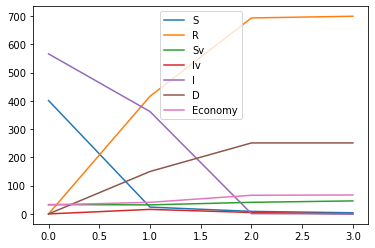

In [11]:
obs = get_meanobs(J_states)
show_pandemic(J_states[7])

In [10]:
for k in np.arange(1,len(J_states)+1):
    print(len(J_states[k]))

4
5
4
4
4
5
4
4
4
4
3
4
4
4
4
4
4
4
4
4
5
4
4
4
4
4
4
4
4
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
5
4
5
4
4
4
4
5
4
5
4
5
4
4
4
5
5
4
4
4
4
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
4
4
4
4
4
5
4
4
4


In [9]:
simulate_fixedaction(test_env_J,action_,100,J_states,J_rewards)
simulate_fixedaction(test_env_S,action_,100,S_states,S_rewards)
simulate_fixedaction(test_env_N,action_,100,N_states,N_rewards)

here 13
check
nocheck
nocheck
nocheck
here 8
check
nocheck
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
here 8
check
nocheck
nocheck
nocheck
here 21
check
nocheck
nocheck
nocheck
here 9
check
nocheck
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 6
check
nocheck
nocheck
nocheck
here 28
check
nocheck
nocheck
here 6
check
nocheck
nocheck
nocheck
here 6
check
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
here 29
check
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 13
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 9
check
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
nocheck
here 17
check
nocheck
nocheck
nocheck
here 9
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 26
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 9
check
no

nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 6
check
nocheck
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 6
check
nocheck
nocheck
nocheck
nocheck
here 9
check
nocheck
nocheck
nocheck
here 19
check
nocheck
nocheck
nocheck
here 10
check
nocheck
nocheck
nocheck
here 10
check
nocheck
nocheck
nocheck
nocheck
here 6
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
nocheck
here 11
check
nocheck
nocheck
nocheck
here 8
check
nocheck
nocheck
nocheck
here 6
check
nocheck
nocheck
nocheck
here 6
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 5
check
nocheck
nocheck
nocheck
here 7
check
nocheck
nocheck
nocheck
nocheck
here 5


In [22]:
J_dead = get_meandead(J_states)
S_dead = get_meandead(S_states)
N_dead = get_meandead(N_states)

print(f" Japan mean dead:{J_dead[0]:.2f} +/- {J_dead[1]:.2f}")
print(f" Niger mean dead:{N_dead[0]:.2f} +/- {N_dead[1]:.2f}")
print(f" Switzerland mean dead:{S_dead[0]:.2f} +/- {S_dead[1]:.2f}")

 Japan mean dead:0.40 +/- 1.48
 Niger mean dead:0.08 +/- 0.37
 Switzerland mean dead:0.33 +/- 1.16


In [23]:
J_inf = get_meaninf(J_states)
S_inf = get_meaninf(S_states)
N_inf = get_meaninf(N_states)

print(f" Japan mean infected:{J_inf[0]:.2f} +/- {J_inf[1]:.2f}")
print(f" Niger mean infected:{N_inf[0]:.2f} +/- {N_inf[1]:.2f}")
print(f" Switzerland mean infected:{S_inf[0]:.2f} +/- {S_inf[1]:.2f}")

 Japan mean infected:6.94 +/- 23.44
 Niger mean infected:9.48 +/- 28.38
 Switzerland mean infected:8.06 +/- 25.61
